In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.linear_model import LinearRegression,LassoCV,RidgeCV,ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [128]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [129]:
house_prices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [130]:
house_prices_df.shape

(1460, 81)

In [131]:
house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [132]:
house_prices_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [133]:
# Some columns are numerical & some are non-numerical
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print('The number of non-numeric columns is {}'.format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numeric columns is 43


In [134]:
numeric_columns = house_prices_df.select_dtypes(['int64','float']).columns
print(numeric_columns)
print('The number of numeric columns is {}'.format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numeric columns is 38


In [135]:
# Missing Data

total_missing = house_prices_df.isnull().sum().sort_values(ascending = False)
percent_missing = (house_prices_df.isnull().sum()/house_prices_df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total_missing,percent_missing], axis =1, keys = ['Total','Percent'])
missing_data.head(25)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garageyrblt,81,0.055479
garagecond,81,0.055479
garagetype,81,0.055479
garagefinish,81,0.055479


In [136]:
# We see 19 features has missing values

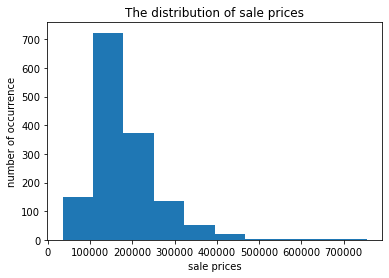

In [137]:
# Exploratory data analysis and feature selection
plt.hist(house_prices_df.saleprice)
plt.title('The distribution of sale prices')
plt.xlabel('sale prices')
plt.ylabel('number of occurrence')
plt.show()

In [138]:
# We derive correlations of the features with our target variable irrespective of their signs by taking absolute values
np.abs(house_prices_df[numeric_columns].iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending = False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

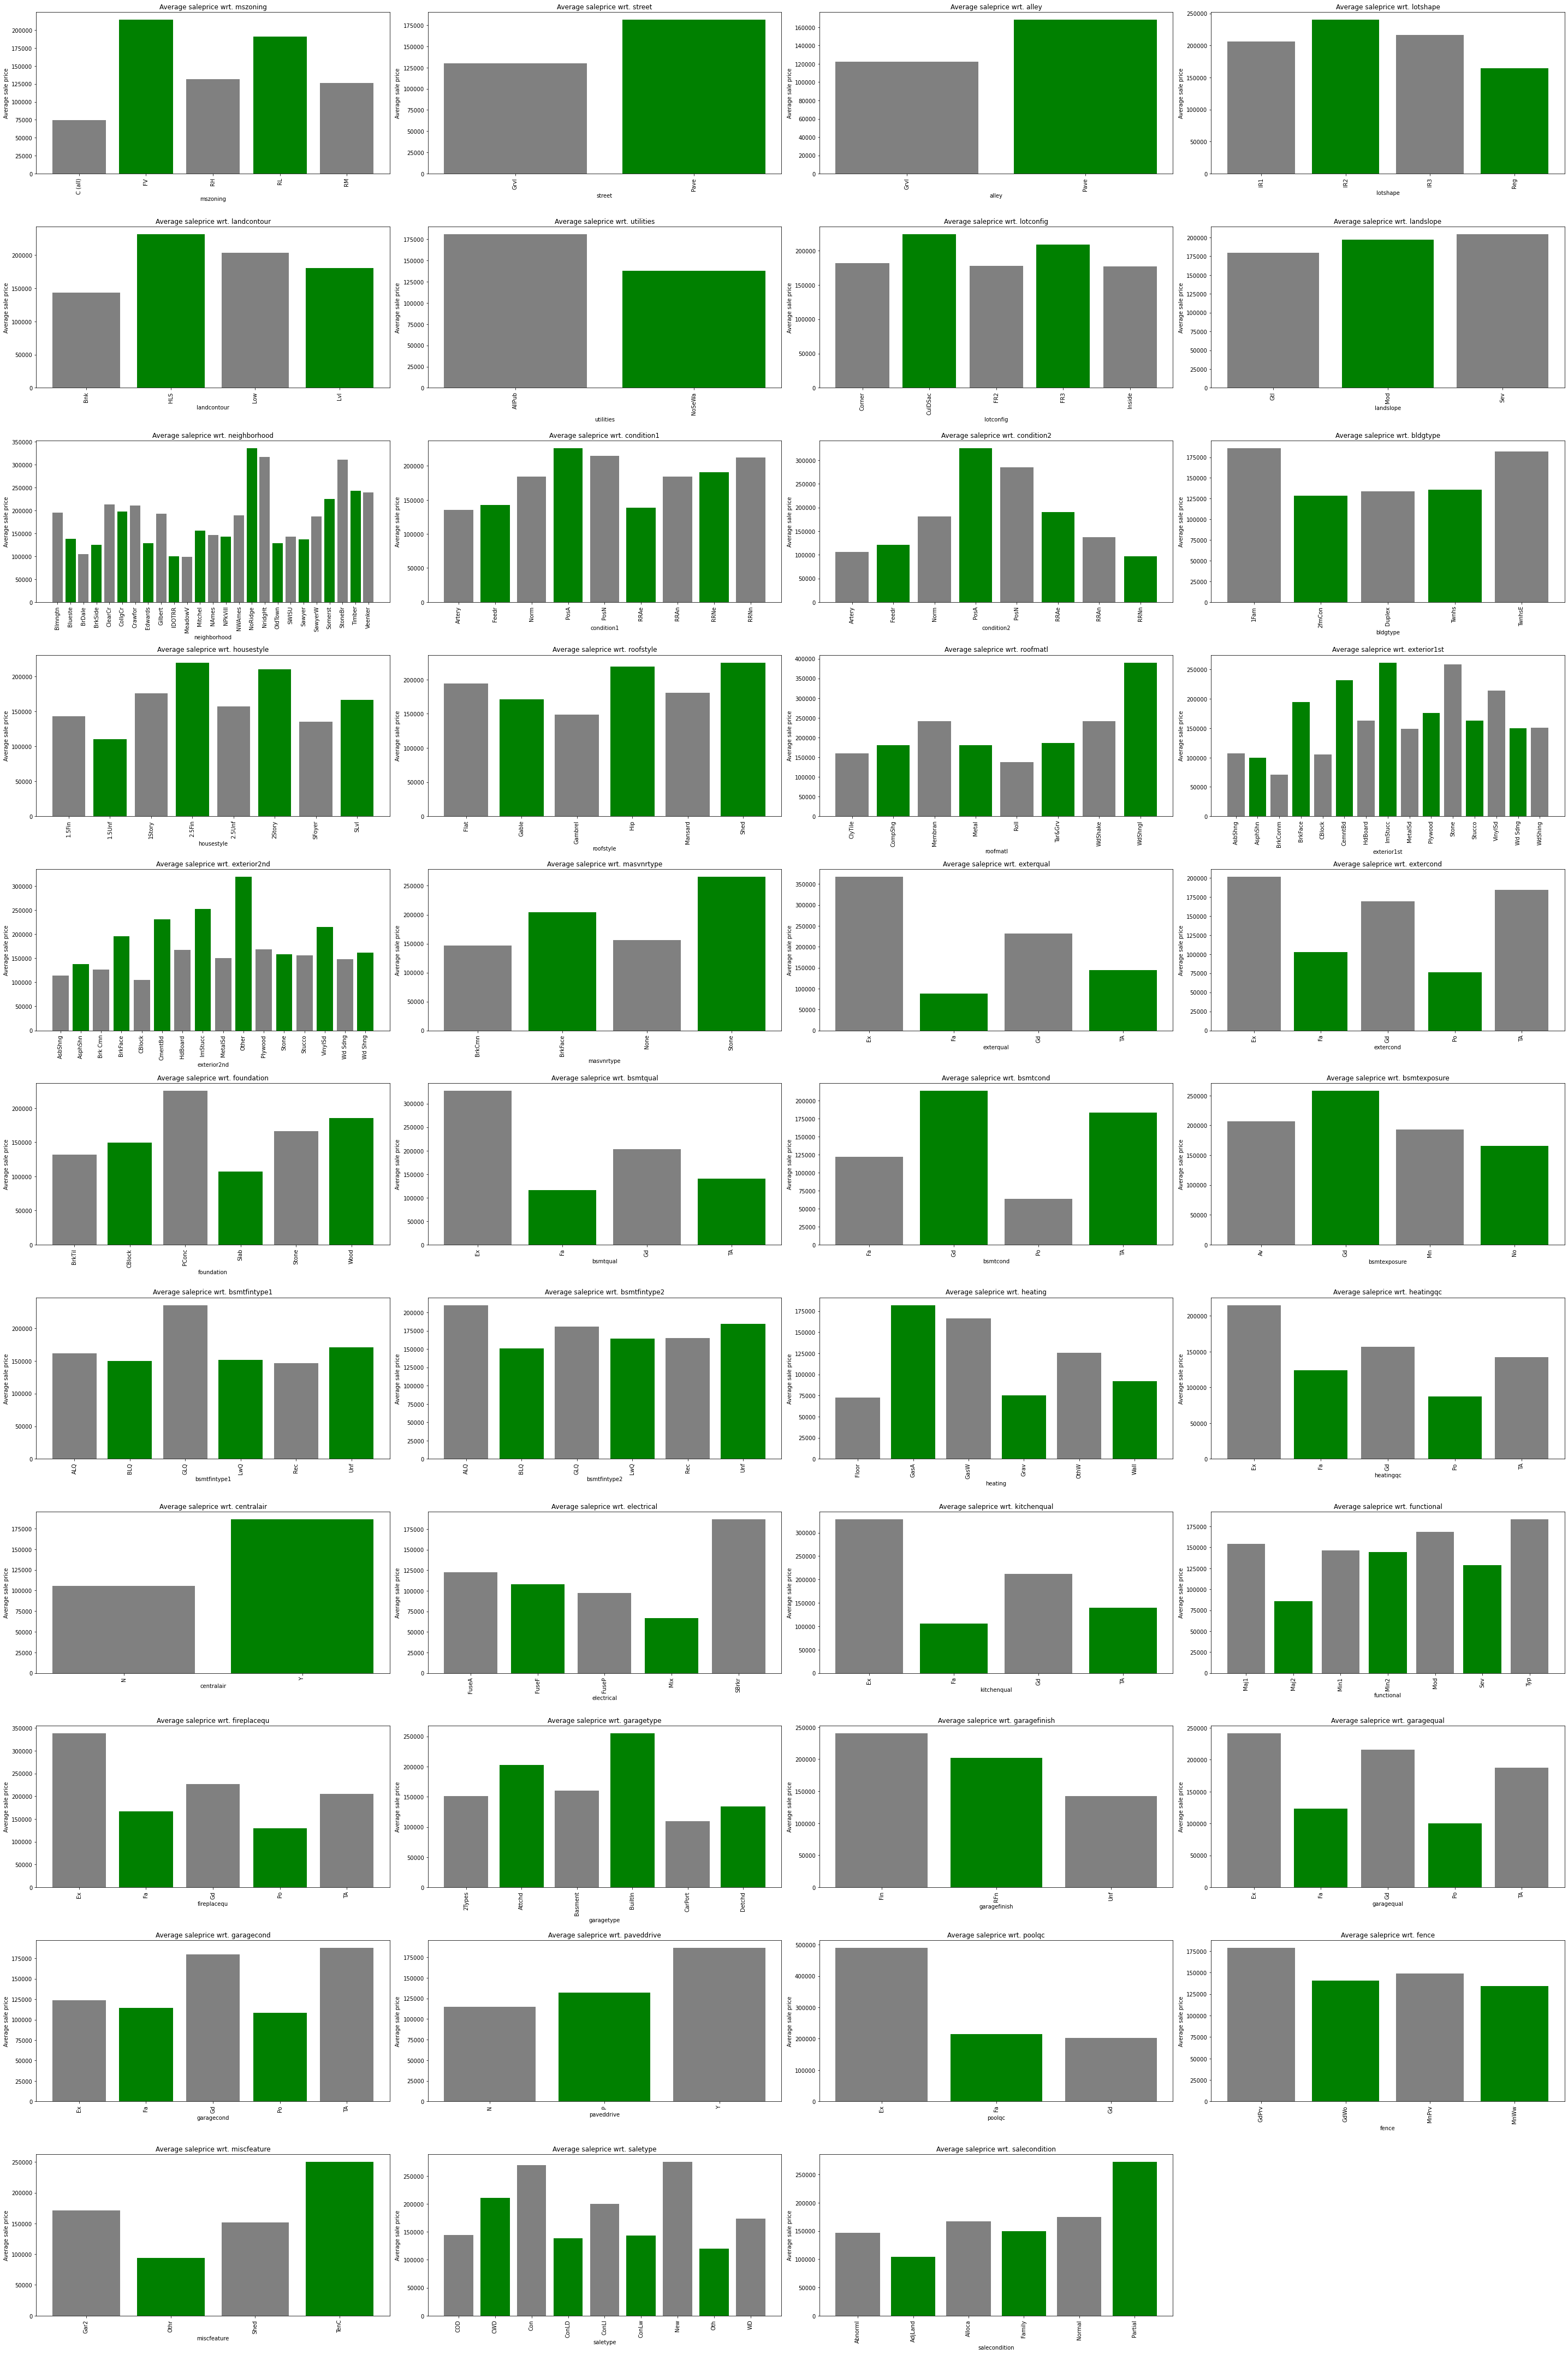

In [139]:
# To understand the univariate relation between our target variable and non-numerical features
plt.figure(figsize = (40,60))
for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)['saleprice'].mean().index,house_prices_df.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [140]:
# As our model, we choose the 5 numerical variables that are most correlated with the saleprice. We also add 2 non-numerical features.

house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning,prefix = 'mszoning',drop_first = True)],axis =1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street,prefix ='street',drop_first = True)],axis =1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning,prefix = 'mszoning',drop_first = True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix = 'street',drop_first = True).columns)


In [141]:
# Regression Model
house_prices_df['totalsf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf']+ house_prices_df['secondflrsf']
house_prices_df['int_over_sf']= house_prices_df['totalsf']*house_prices_df['overallqual']
# Y is the target variable
Y = np.log1p(house_prices_df['saleprice'])
# X is the feature
X = house_prices_df[['overallqual','grlivarea','garagecars','garagearea','totalsf','int_over_sf'] + dummy_column_names]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,random_state = 465)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [142]:
lrm = LinearRegression()
lrm.fit(X_train,y_train)
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)
print("R-squared of the model in training set is: {}".format(lrm.score(X_train,y_train)))
print("-----Test set statistics----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test,y_test)))
print("Mean absolute error of the prediction is : {}".format(mean_absolute_error(y_test,y_preds_test)))
print("Mean squared error of the prediction is : {}".format(mse(y_test,y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test,y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test-y_preds_test)/y_test))*100))

R-squared of the model in training set is: 0.832132255313275
-----Test set statistics----
R-squared of the model in test set is: 0.8249302330916422
Mean absolute error of the prediction is : 0.1257037287286162
Mean squared error of the prediction is : 0.029192121871357144
Root mean squared error of the prediction is: 0.1708570217209616
Mean absolute percentage error of the prediction is: 1.050357766782369


In [143]:
lasso_cv = LassoCV(alphas= alphas, cv =5)
lasso_cv.fit(X_train,y_train)
# We are making predictions
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)
print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model is : {}".format(lasso_cv.score(X_train,y_train)))
print("----Test set statistics----")
print("R-squared of the model in test set is : {}".format(lasso_cv.score(X_test,y_test)))
print(" Mean absolute error of the prediction is: {}".format(mse(y_test,y_preds_test)))
print("Root mean  squared error of the prediction is: {}".format(rmse(y_test,y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test-y_preds_test)/y_test))*100))

Best alpha value is: 0.0001
R-squared of the model is : 0.831939428704242
----Test set statistics----
R-squared of the model in test set is : 0.8226434437869413
 Mean absolute error of the prediction is: 0.02957343403767703
Root mean  squared error of the prediction is: 0.17196928225028163
Mean absolute percentage error of the prediction is: 1.0552354946577738


In [144]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train,y_train)
# We are making predictions
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)
print("Best alpha value is : {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is : {}".format(ridge_cv.score(X_train,y_train)))
print("----Test set statistics----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test,y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test,y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test,y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test,y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test-y_preds_test)/y_test))*100))

Best alpha value is : 1.0
R-squared of the model in training set is : 0.8316364867222639
----Test set statistics----
R-squared of the model in test set is: 0.8203050076234285
Mean absolute error of the prediction is: 0.1267363733974106
Mean squared error of the prediction is: 0.029963358092978874
Root mean squared error of the prediction is: 0.17309927236409423
Mean absolute percentage error of the prediction is: 1.0596941230310677


In [145]:
elasticnet_cv = ElasticNetCV(alphas = alphas, cv =5)
elasticnet_cv.fit(X_train,y_train)
# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)
print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-sqaured of the model in training set is: {}".format(elasticnet_cv.score(X_train,y_train)))
print("---Test set statistics---")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test,y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test,y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test,y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test,y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test-y_preds_test)/y_test))*100))

Best alpha value is: 0.001
R-sqaured of the model in training set is: 0.8299654806803801
---Test set statistics---
R-squared of the model in test set is: 0.8149185869526185
Mean absolute error of the prediction is: 0.12770726087011358
Mean squared error of the prediction is: 0.030861520302533824
Root mean squared error of the prediction is: 0.17567447254092958
Mean absolute percentage error of the prediction is: 1.0685444897303122


In [146]:
# From the prediction results we find that the best model is the OLS regression model

In [147]:
# Integrating new factors that affect the target variable but are not there in the dataset 

In [148]:
yr_sold= pd.DataFrame(house_prices_df.yrsold)
yr_sold

,yrsold
0,2008
1,2007
2,2008
3,2006
4,2008
...,...
1455,2007
1456,2010
1457,2010
1458,2010


In [149]:
yr_sold.describe()

,yrsold
count,1460.000000
mean,2007.815753
std,1.328095
min,2006.000000
25%,2007.000000
50%,2008.000000
75%,2009.000000
max,2010.000000


In [150]:
# Economic factors affecting house prices: mortgage rate, unemployment rate,gdp, population growth, federal funds rate, cpi

mortgage_rate= pd.read_csv('C:/Users/chowd/OneDrive/Desktop/Thinkful assignments/MORTGAGE30US.csv')
unemployment_rate = pd.read_csv('C:/Users/chowd/OneDrive/Desktop/Thinkful assignments/UNEMPLOYMENTRATE.csv')
gdp= pd.read_csv('C:/Users/chowd/OneDrive/Desktop/Thinkful assignments/GDP.csv')
pop_growth = pd.read_csv('C:/Users/chowd/OneDrive/Desktop/Thinkful assignments/SPPOPGROWUSA.csv')
federal_funds_rate = pd.read_csv('C:/Users/chowd/OneDrive/Desktop/Thinkful assignments/Federal_funds_rate.csv')
cpi = pd.read_csv('C:/Users/chowd/OneDrive/Desktop/Thinkful assignments/CPI.csv')

In [151]:
mortgage_rate['DATE'] = pd.to_datetime(mortgage_rate['DATE'])
unemployment_rate['DATE']= pd.to_datetime(unemployment_rate['DATE'])
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
pop_growth['DATE'] = pd.to_datetime(pop_growth['DATE'])
federal_funds_rate['DATE']= pd.to_datetime(federal_funds_rate['DATE'])
cpi['DATE'] = pd.to_datetime(cpi['DATE'])

In [152]:
mortgage_rate= mortgage_rate[mortgage_rate['DATE'].dt.year >= 2006]
unemployment_rate = unemployment_rate[unemployment_rate['DATE'].dt.year >= 2006]
gdp = gdp[gdp['DATE'].dt.year >= 2006]
federal_funds_rate= federal_funds_rate[federal_funds_rate['DATE'].dt.year >= 2006]
cpi = cpi[cpi['DATE'].dt.year >= 2006]

In [153]:
house_prices_df.yrsold.head(10)

0    2008
1    2007
2    2008
3    2006
4    2008
5    2009
6    2007
7    2009
8    2008
9    2008
Name: yrsold, dtype: int64

In [154]:
mortgage_rate.head(10)

,DATE,MORTGAGE30US
1814,2006-01-05,6.21
1815,2006-01-12,6.15
1816,2006-01-19,6.10
1817,2006-01-26,6.12
1818,2006-02-02,6.23
1819,2006-02-09,6.24
1820,2006-02-16,6.28
1821,2006-02-23,6.26
1822,2006-03-02,6.24
1823,2006-03-09,6.37


In [155]:
mortgage_df= mortgage_rate.groupby([mortgage_rate['DATE'].dt.year]).mean()
unemployment_df = unemployment_rate.groupby([unemployment_rate['DATE'].dt.year]).mean()
gdp_df = gdp.groupby([gdp['DATE'].dt.year]).mean()
federal_funds_df = federal_funds_rate.groupby([federal_funds_rate['DATE'].dt.year]).mean()
cpi_df = cpi.groupby([cpi['DATE'].dt.year]).mean()

In [156]:
mortgage_df.index

Int64Index([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
           dtype='int64', name='DATE')

In [157]:
merge_df = pd.merge(house_prices_df,mortgage_df,left_on= 'yrsold',right_index= True,how = 'left')
house_prices_df['Final_mortgage_rate'] = merge_df['MORTGAGE30US']

In [158]:
merge_df = pd.merge(house_prices_df,unemployment_df,left_on= 'yrsold',right_index= True,how = 'left')
house_prices_df['Unemployment Rate'] = merge_df['UNRATE']

In [159]:
merge_df = pd.merge(house_prices_df,gdp_df,left_on= 'yrsold',right_index= True,how = 'left')
house_prices_df['Gdp'] = merge_df['GDP']

In [160]:
merge_df = pd.merge(house_prices_df,federal_funds_df,left_on= 'yrsold',right_index = True ,how = 'left')
house_prices_df['Federal funds rate'] = merge_df['DFF']

In [161]:
merge_df = pd.merge(house_prices_df,cpi_df,left_on= 'yrsold',right_index= True,how = 'left')
house_prices_df['Cpi'] = merge_df['FPCPITOTLZGUSA']
house_prices_df

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,mszoning_RL,mszoning_RM,street_Pave,totalsf,int_over_sf,Final_mortgage_rate,Unemployment Rate,Gdp,Federal funds rate,Cpi
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,1,0,1,2566,17962,6.027170,5.800000,14769.86175,NaN,3.839100
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,1,0,1,2524,15144,6.337308,4.616667,14474.22700,NaN,2.852672
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,1,0,1,2706,18942,6.027170,5.800000,14769.86175,NaN,3.839100
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,1,0,1,2473,17311,6.413269,4.608333,13815.58300,NaN,3.225944
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,1,0,1,3343,26744,6.027170,5.800000,14769.86175,NaN,3.839100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,...,1,0,1,2600,15600,6.337308,4.616667,14474.22700,NaN,2.852672
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,...,1,0,1,3615,21690,4.689808,9.608333,15048.97100,NaN,1.640043
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,...,1,0,1,3492,24444,4.689808,9.608333,15048.97100,NaN,1.640043
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,...,1,0,1,2156,10780,4.689808,9.608333,15048.97100,NaN,1.640043


In [164]:
house_prices_df['Federal funds rate'].head(3)

0   NaN
1   NaN
2   NaN
Name: Federal funds rate, dtype: float64